# Address completeness classification with traditional programming techniques
Data & AI course, UC Leuven, 2021 Fall
### Project supervisors
- Tom Magerman
- Aimée Lynn Backiel

### Project team (Group 4)
- Karolis Medekša
- Pedro Teixeira Palma Rosa
- Hysa Mello de Alcântara
- Josep Jacob Chetrit Valdepeñas

## Goals
The goal if the assignment to implement a Python program that is capable of determining whether a provided street address is complete (having a street name, house/apartment number, postal code, city) or incomplete (missing any of previously mentioned criteria).

# Implementation
The first step of solving the problem is reading the input file into an object of `pandas.DataFrame`. Function `read_DataFrame_from_file` is responsible for that. While doing the exercise it is also convenient to output the data table to excel for an easier inspection, `write_DataFrame_to_excel` is responsible for that, the function not only outputs the data frame to an excel file, but also adds additional formatting, for instance, coloring rows of complete addresses in green and those that are incomplete - in red.  

In [1]:
import pandas as pd

DATA_INPUT_FILENAME = 'input.txt'
DATA_OUTPUT_FILENAME = 'classified.xlsx'

def read_DataFrame_from_file():
    return pd.read_csv(DATA_INPUT_FILENAME, delimiter='\t')


def write_DataFrame_to_excel(df: pd.DataFrame):
    sheet_name = 'Classified'

    with pd.ExcelWriter(DATA_OUTPUT_FILENAME, engine='xlsxwriter') as writer:
        df.to_excel(writer, sheet_name=sheet_name, index=False)
        
        worksheet = writer.sheets[sheet_name]
        # format all data as a table
        worksheet.add_table(0, 0, df.shape[0], df.shape[1]-1, {
            'columns': [{'header': col_name} for col_name in df.columns],
            'style': 'Table Style Medium 5'
        })
        # Widen the address column
        worksheet.set_column('C:C', 70)

        # Add formatting - red for negative, green - for positive qualification
        redFormat = writer.book.add_format({'bg_color': '#FF0000', 'font_color': '#000000'})
        greenFormat = writer.book.add_format({'bg_color': '#00B050', 'font_color': '#000000'})
        worksheet.conditional_format(0, 0, df.shape[0], df.shape[1]-1, {'type': 'formula',
                                          'criteria': '=$E1=0',
                                          'format': redFormat})
        worksheet.conditional_format(0, 0, df.shape[0], df.shape[1]-1, {'type': 'formula',
                                          'criteria': '=$E1=1',
                                          'format': greenFormat})

With the simplest possible strategy of classification (label all addresses as incomplete) we can verify that input/output behavior is working correctly

In [2]:
def classify_address(dataFrame: pd.DataFrame):
    dataFrame['complete'] = 0
    return dataFrame


def init():
    classified = classify_address(read_DataFrame_from_file())
    write_DataFrame_to_excel(classified)


init()

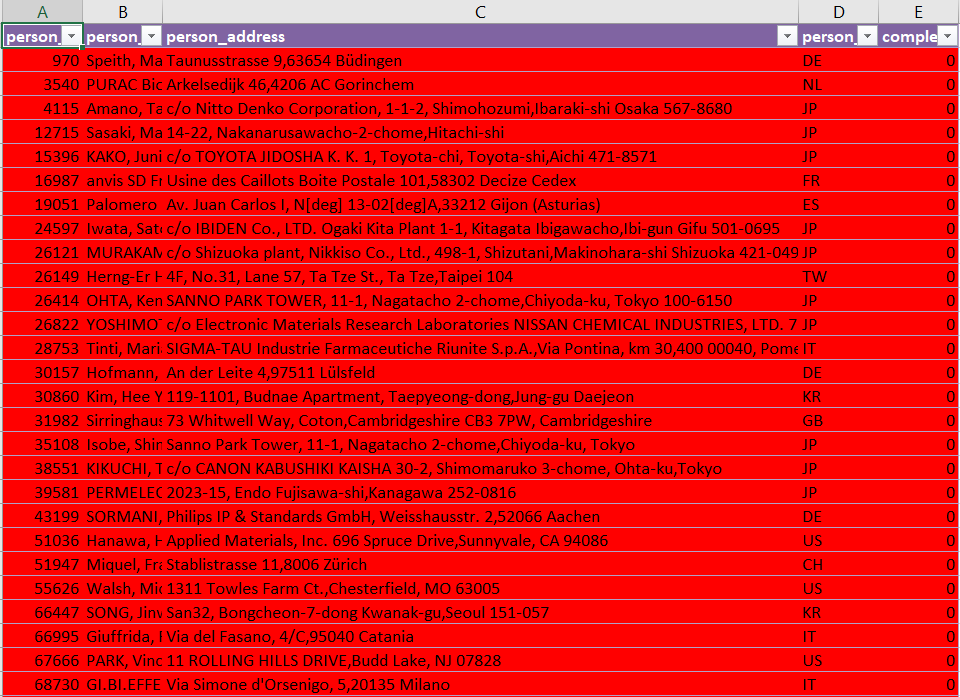


# Address classification strategy

For the solution of this exercise several options were considered:
- Using regular expressions to find street names, house numbers, cities and postal codes. ReGex could work for a postal code, but other tokens are just too varying, even within the same country, to confidently create a single solution with regular expressions
- Searching a database of city/street names for matches in the address string. Due to an overwhelming number of street names in the world coding a solution for all of them is unfeasable. There are less city names, but even checking for them is troublesome - city's name could be anywhere within the address and they could be in different languages to boot.
- Using an already created address parsing library. Although easiest to implement, relying only on a library could end up being troublesome once it's limitations are reached.

## libpostal
An open source `C` library [libpostal](https://github.com/openvenues/libpostal) was chosen to parse the addresses, mainly because it provides wide parsing support across different countries and languages - relevant for the input dataset. 

On the other hand, the library is developed mainly for usage in `UNIX` operating systems, therefore, installing it on Windows OS is very troublesome. As an alternative it was decided to run an instance of a `libpostal` tool in a docker container.

For the implementation of the solution a Dockerfile from [Pelias project](https://github.com/pelias/libpostal-service) was used. It creates a container with an instance of a [Go web server](https://github.com/whosonfirst/go-whosonfirst-libpostal) which allows using `libpostal` via REST API.

### Setting up the docker container

1. Make sure that docker is installed on the host system
2. Build and start the docker container
```shell
docker run --name libpostal -d -p 4400:4400 pelias/libpostal-service
```
The command will pull the docker image from a remote repository along with all the data required for the service. Execution of the command can take a couple of minutes.
3. Verify that the service is working correctly
```shell
curl -s localhost:4400/parse?address=30+w+26th+st,+new+york,+ny
[{"label":"house_number","value":"30"},{"label":"road","value":"w 26th st"},{"label":"city","value":"new york"},{"label":"state","value":"ny"}]
```

### Using libpostal via API

The address can be parsed by simply passing it to the service entry point. Variuos information is extracted by the tool: street (road), house number, city, state, postal code and more.

```shell
curl -s localhost:4400/parse?address=83%20Sycamore%20Drive%2CReading%2C%20Pennsylvania%2019606 | py -m json.tool
[
    {
        "label": "house_number",
        "value": "83"
    },
    {
        "label": "road",
        "value": "sycamore drive"
    },
    {
        "label": "city",
        "value": "reading"
    },
    {
        "label": "state",
        "value": "pennsylvania"
    },
    {
        "label": "postcode",
        "value": "19606"
    }
]

```

### Using the library for classification
We can call the API to classify each address in the python script:

In [3]:
import requests

LIBPOSTAL_API_PARSE_PATH = 'http://localhost:4400/parse'

def enrich_row_with_address_details(row):
    error_response = [0, None, None, None, None]

    address = row['person_address']
    if not address:
        return error_response

    response = {}
    try:
        unmapped_response = requests.get(LIBPOSTAL_API_PARSE_PATH, params={ 'address': address }).json()
        response = { entry['label']: entry['value'] for entry in unmapped_response }
    except Exception as e:
        print('Failed to parse address {} | error: {}'.format(address, e))
        return error_response

    street = response['road'] if 'road' in response else None
    house_number = response['house_number']  if 'house_number' in response else None
    post_code = response['postcode']  if 'postcode' in response else None
    city = response['city']  if 'city' in response else None

    complete = 1 if street and house_number and post_code and city else 0
    
    return complete, street, house_number, post_code, city


def classify_address(dataFrame: pd.DataFrame):
    dataFrame[['complete', 'street', 'house', 'postal_code', 'city']] = dataFrame.apply(enrich_row_with_address_details, axis=1, result_type='expand')
    return dataFrame


def init():
    classified = classify_address(read_DataFrame_from_file())
    write_DataFrame_to_excel(classified)


init()

We can see that only a portion of all addresses are qualified correctly:
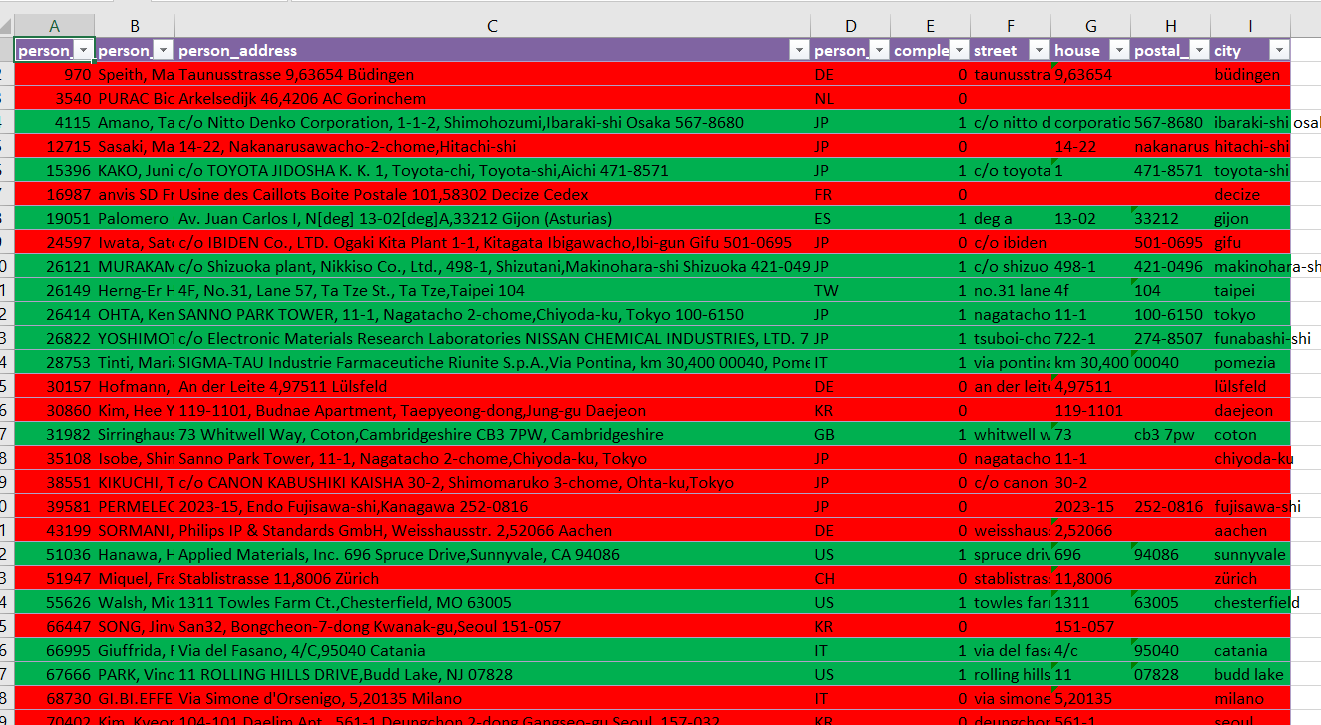

# Shortcomings of the library

One of the issues is that the library sometimes gets confused if the address tokens are separated by commas not followed by a space. An example:



Taunusstrasse 9,63654 Büdingen:
```shell
curl -s localhost:4400/parse?address=Taunusstrasse%209%2C63654%20B%C3%BCdingen | py -m json.tool
[
    {
        "label": "road",
        "value": "taunusstrasse"
    },
    {
        "label": "house_number",
        "value": "9,63654"
    },
    {
        "label": "city",
        "value": "b\u00c3\u00bcdingen"
    }
]
```
Taunusstrasse 9, 63654 Büdingen:
```shell
curl -s localhost:4400/parse?address=Taunusstrasse%209%2C%2063654%20B%C3%BCdingen | py -m json.tool
[
    {
        "label": "road",
        "value": "taunusstrasse"
    },
    {
        "label": "house_number",
        "value": "9"
    },
    {
        "label": "postcode",
        "value": "63654"
    },
    {
        "label": "city",
        "value": "b\u00c3\u00bcdingen"
    }
]

```

After changing the code to replace all commas into commas with trailing spaces (`address = address.replace(',', ', ')`), we get more correct classifications:
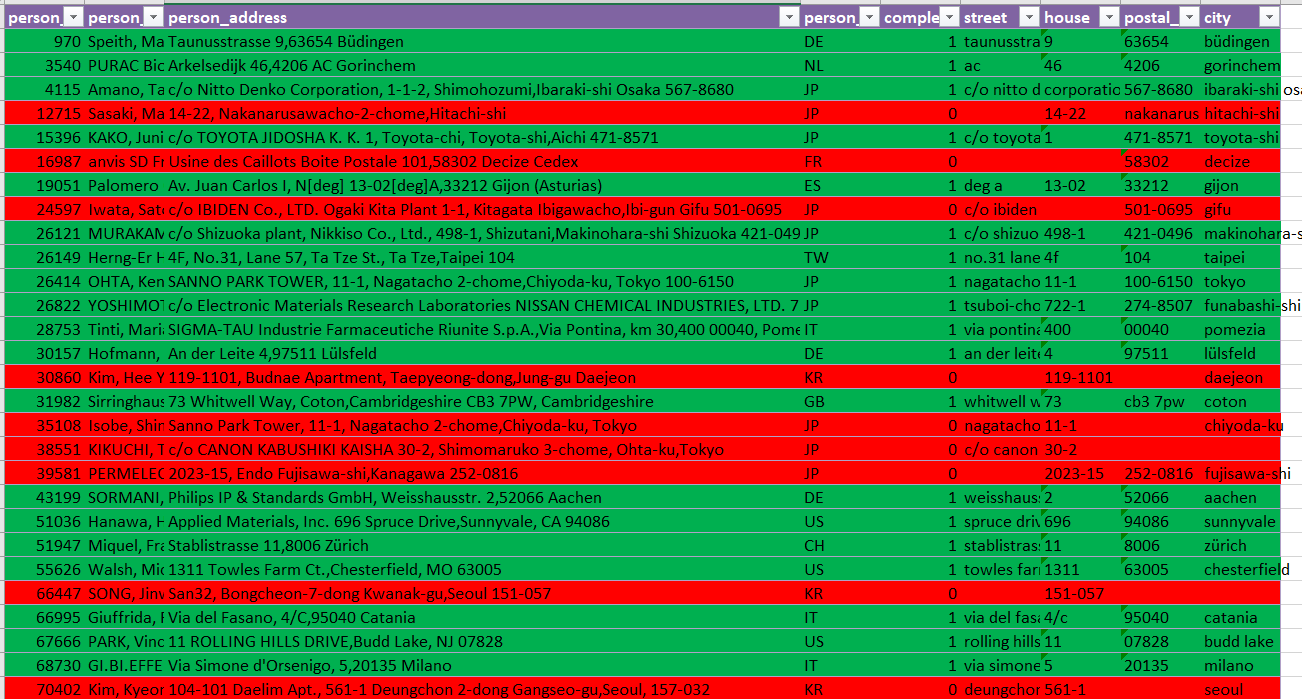

## Misclassification of the postal code
In some cases the postal code can be misqualified, for instance, as a house number. Some examples where that can happen:
- Postal code classified as a part of the house number

This can happen in some cases when the postal code comes right after the house number.

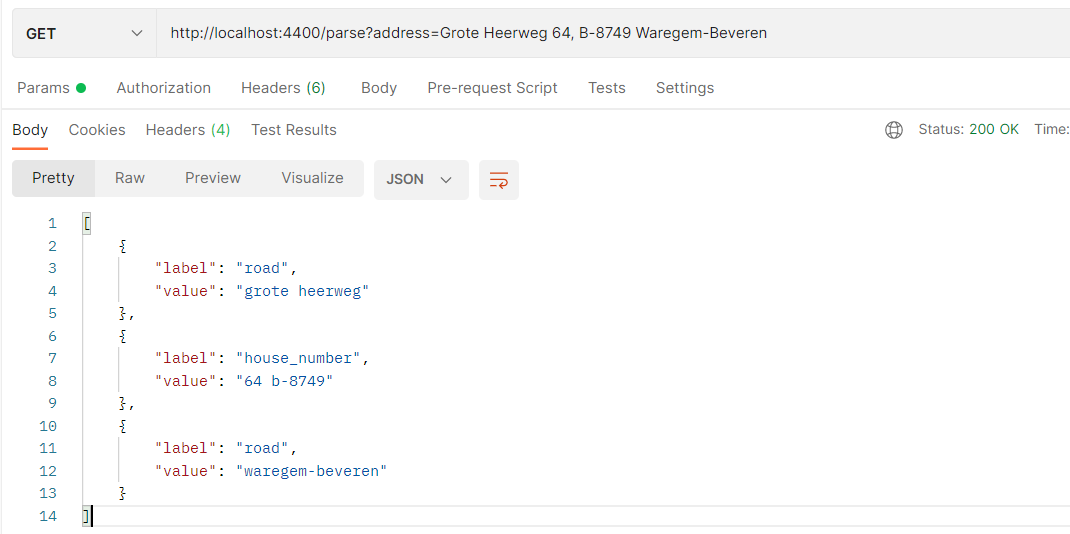
- Postal code misqualified as a house number

This, in some cases, can happen if a postal code comes before the house number:
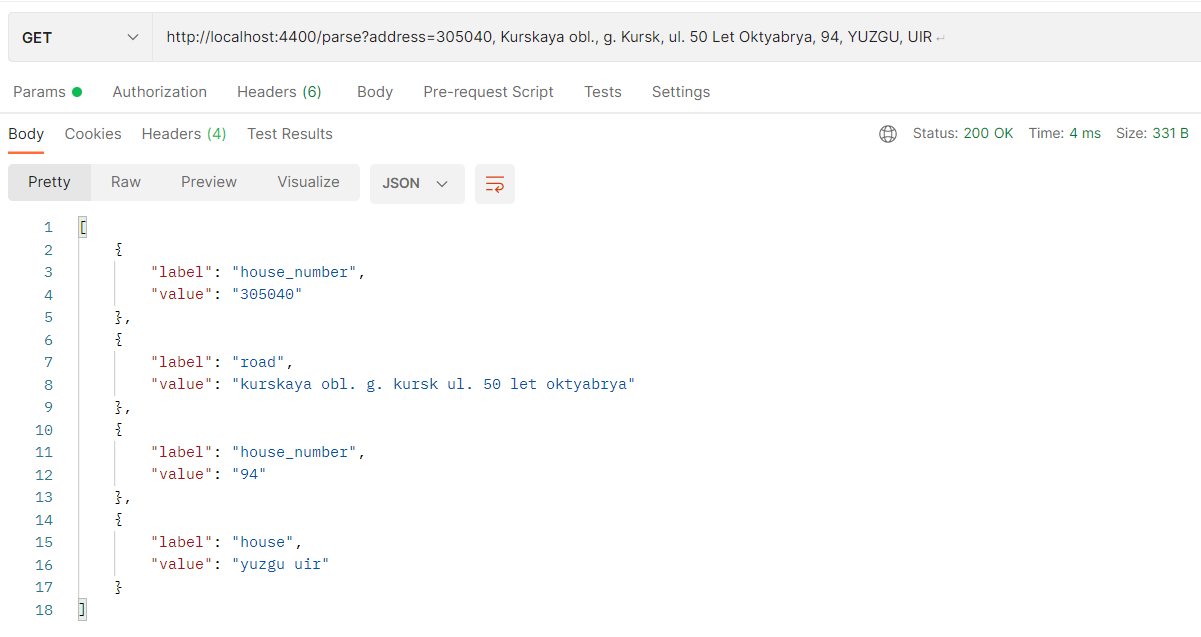

These misqualifications were quite common, especially with German addresses:
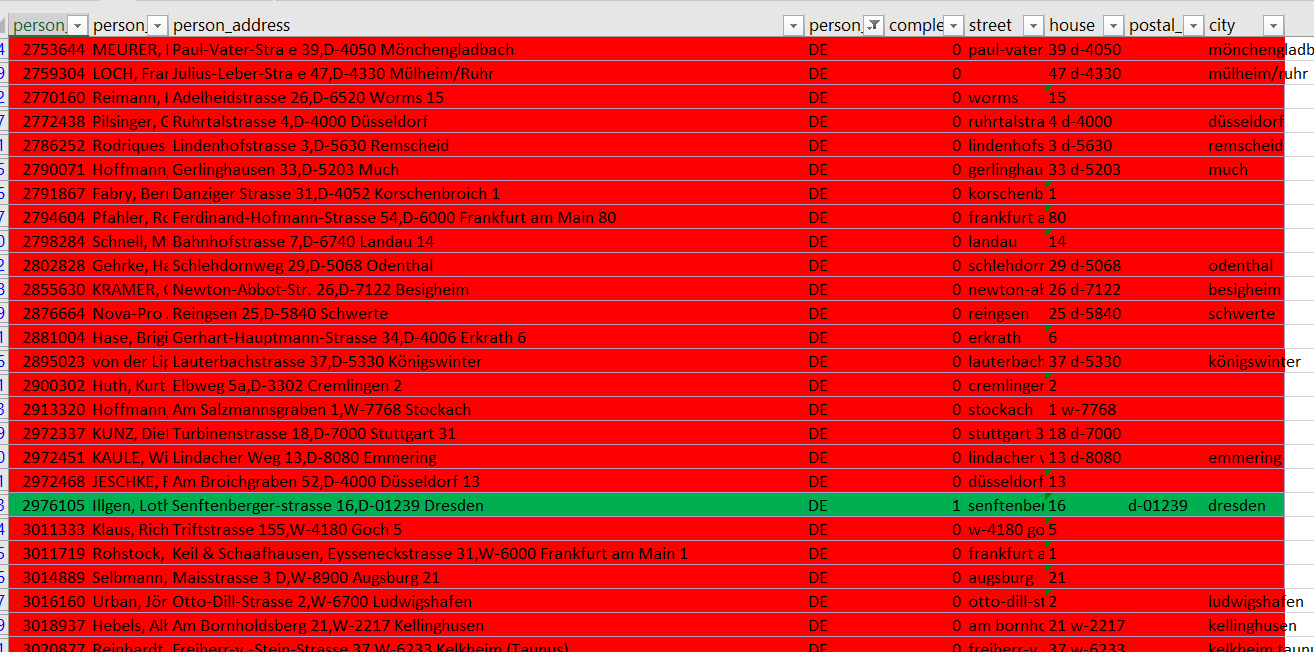

### Resolving misqualified postal codes
One way to mitigate the misqualification of the postal code is to check the house number fields whether any of the values match the format of a postal code, then, verifying if there are remaining tokens for a house code.

Regular expressions can be used to match postal codes in different formats:
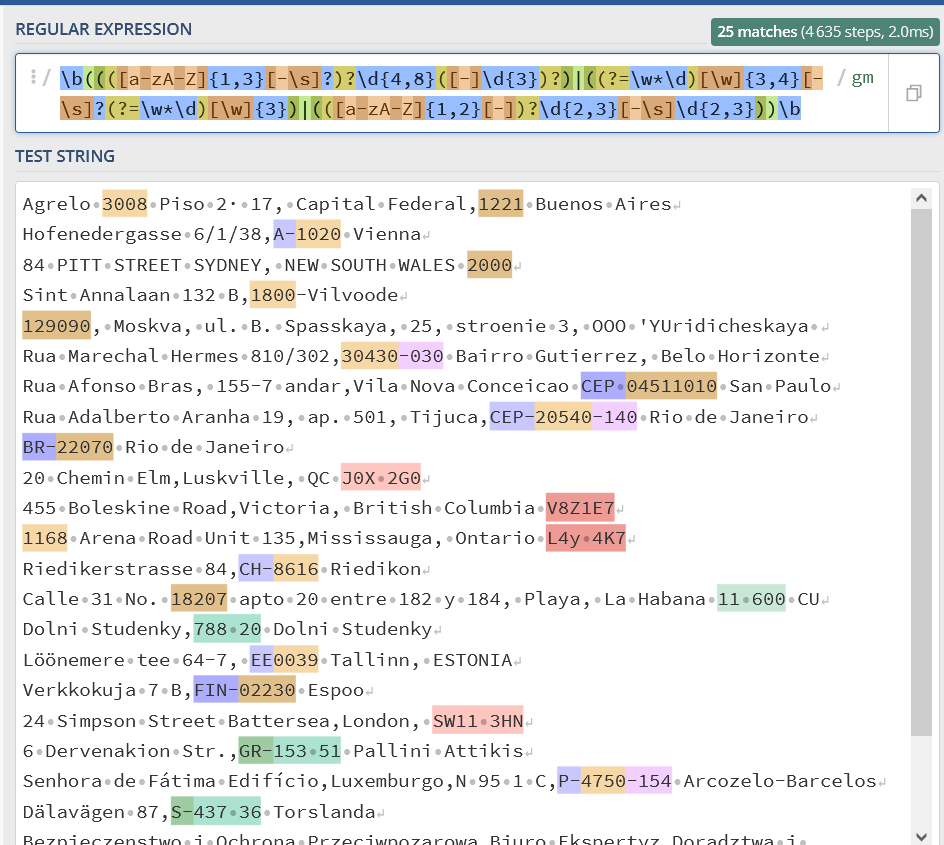

We can now implement a `reGex` check to test whether a string value contains a sequence matching a postal code format:

In [4]:
def collect_property_list(property, array):
    return list(map(lambda row: row['value'] , filter(lambda row: row['label'] == property , array)))


def get_normalized_house_number_and_postal(house_numbers):
    house_num = None
    postal = None

    for number in house_numbers:
        if house_num and postal:
            break
        possible_postal = extract_postal_code(number)

        if not postal and possible_postal:
            postal = possible_postal
            number = number.replace(possible_postal, '').strip()

        if not house_num and number and len(re.findall(r'\d+', number)) > 0:
            house_num = number

    return house_num, postal


def enrich_row_with_address_details(row):
    error_response = [0, None, None, None, None]

    address = row['person_address']
    country = row['person_ctry_code']

    if not address:
        return error_response
    
    address = address.replace(',', ', ')
    address = address.replace(' - ', '-')

    try:
        unmapped_response = requests.get(LIBPOSTAL_API_PARSE_PATH, params={ 'address': address }).json()
    except Exception as e:
        print('Failed to parse address {} | error: {}'.format(address, e))
        return error_response

    roads = collect_property_list('road', unmapped_response)
    house_numbers = collect_property_list('house_number', unmapped_response)
    post_codes = collect_property_list('postcode', unmapped_response)
    cities = collect_property_list('city', unmapped_response)

    street = roads[0] if len(roads) > 0 else None
    house_number = house_numbers[0] if len(house_numbers) > 0 else None
    post_code = post_codes[0] if len(post_codes) > 0 else None
    city = cities[0] if len(cities) > 0 else None

    if house_number and not post_code:
        # Try and resolve a postal code possibly classified as a house number
        tmp_house_num, tmp_postal = get_normalized_house_number_and_postal(house_numbers)
        if tmp_house_num and tmp_postal:
            house_number = tmp_house_num
            post_code = tmp_postal
            if street and house_number and post_code and city:
                print('NORMALIZED POSTAL CODE FROM HOUSE NUMBER FOR ', address)

    
    complete = 1 if street and house_number and post_code and city else 0

    return complete, street, house_number, post_code, city


The updated solution fixes issues with postal codes being classified as house numbers:
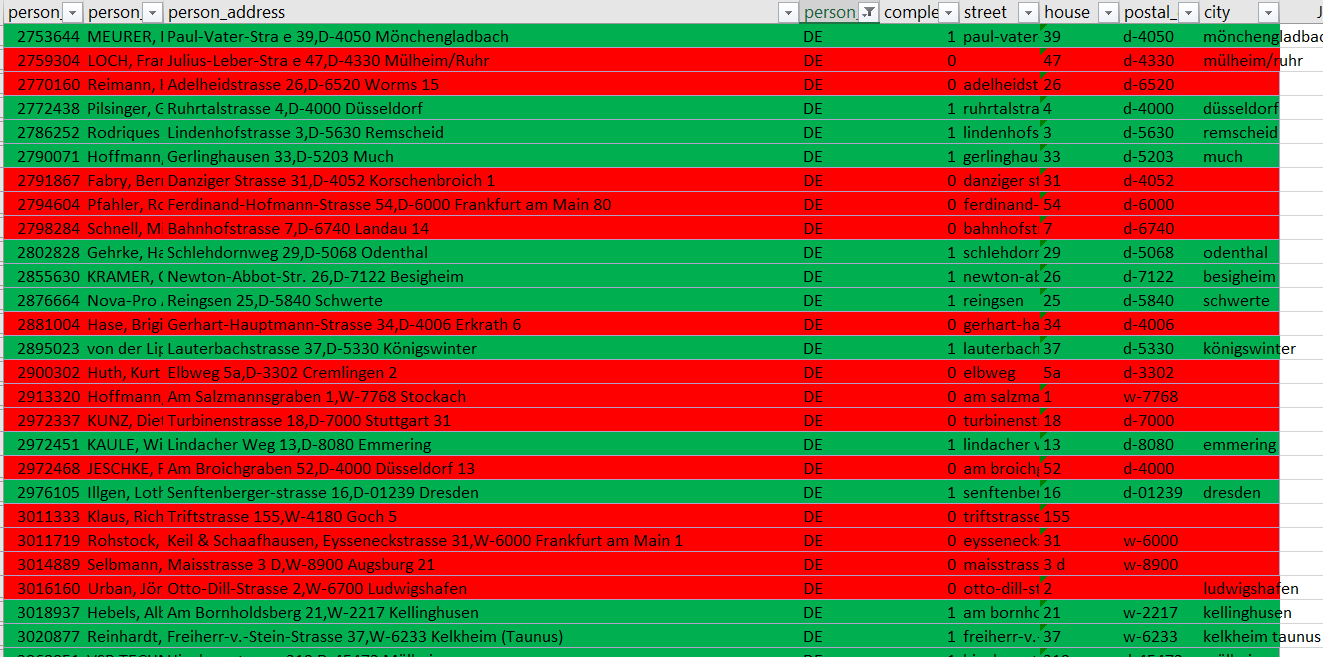

## Classification of Asian addresses

It could also be noticed, that a large amount of Asian country addresses (Japanese, Korean, Chinese, etc.) are qualified as incomplete:
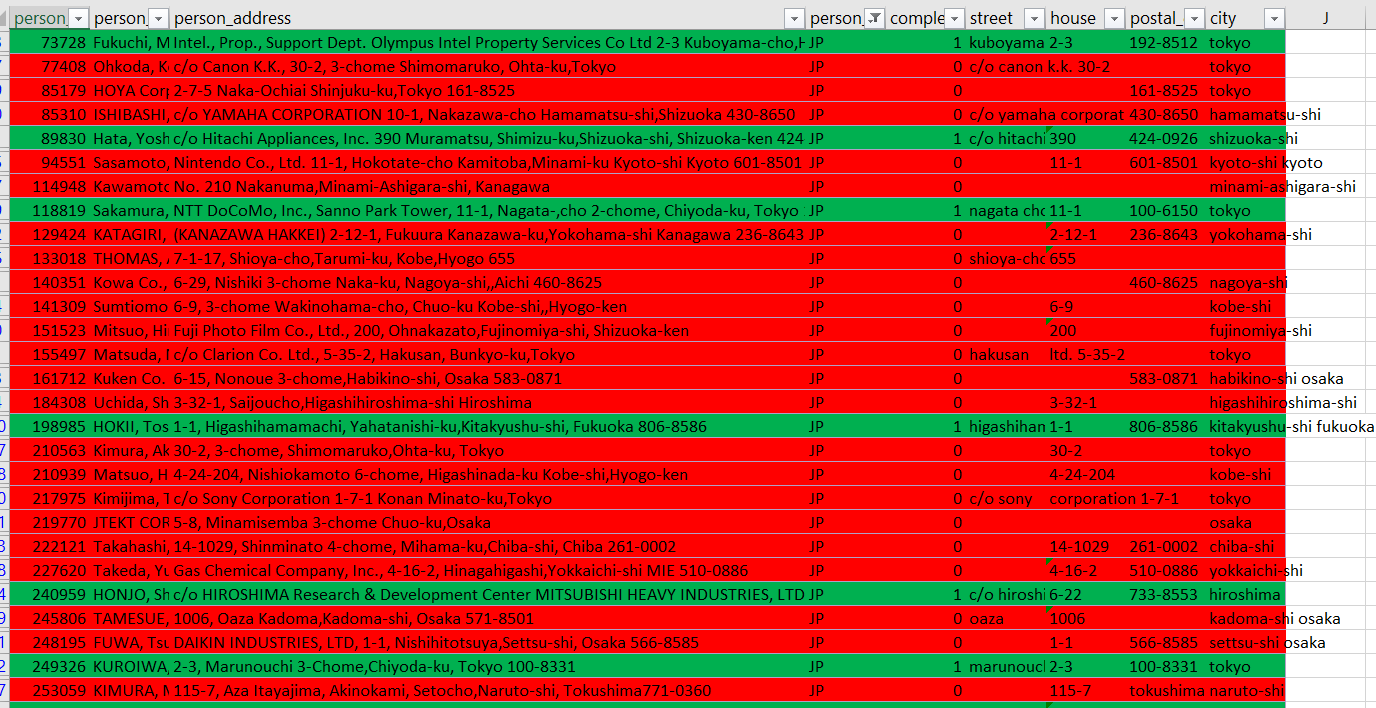

## Japan Example
In order to be able to classify the addresses of Asian countries, we had to look for another way, as we noticed that they were different from European addresses and for that we had to do a little research on how addresses are represented in Asia. We use Japan as an example to try to understand how addresses work in Asia, as it is very similar in other Asian countries.

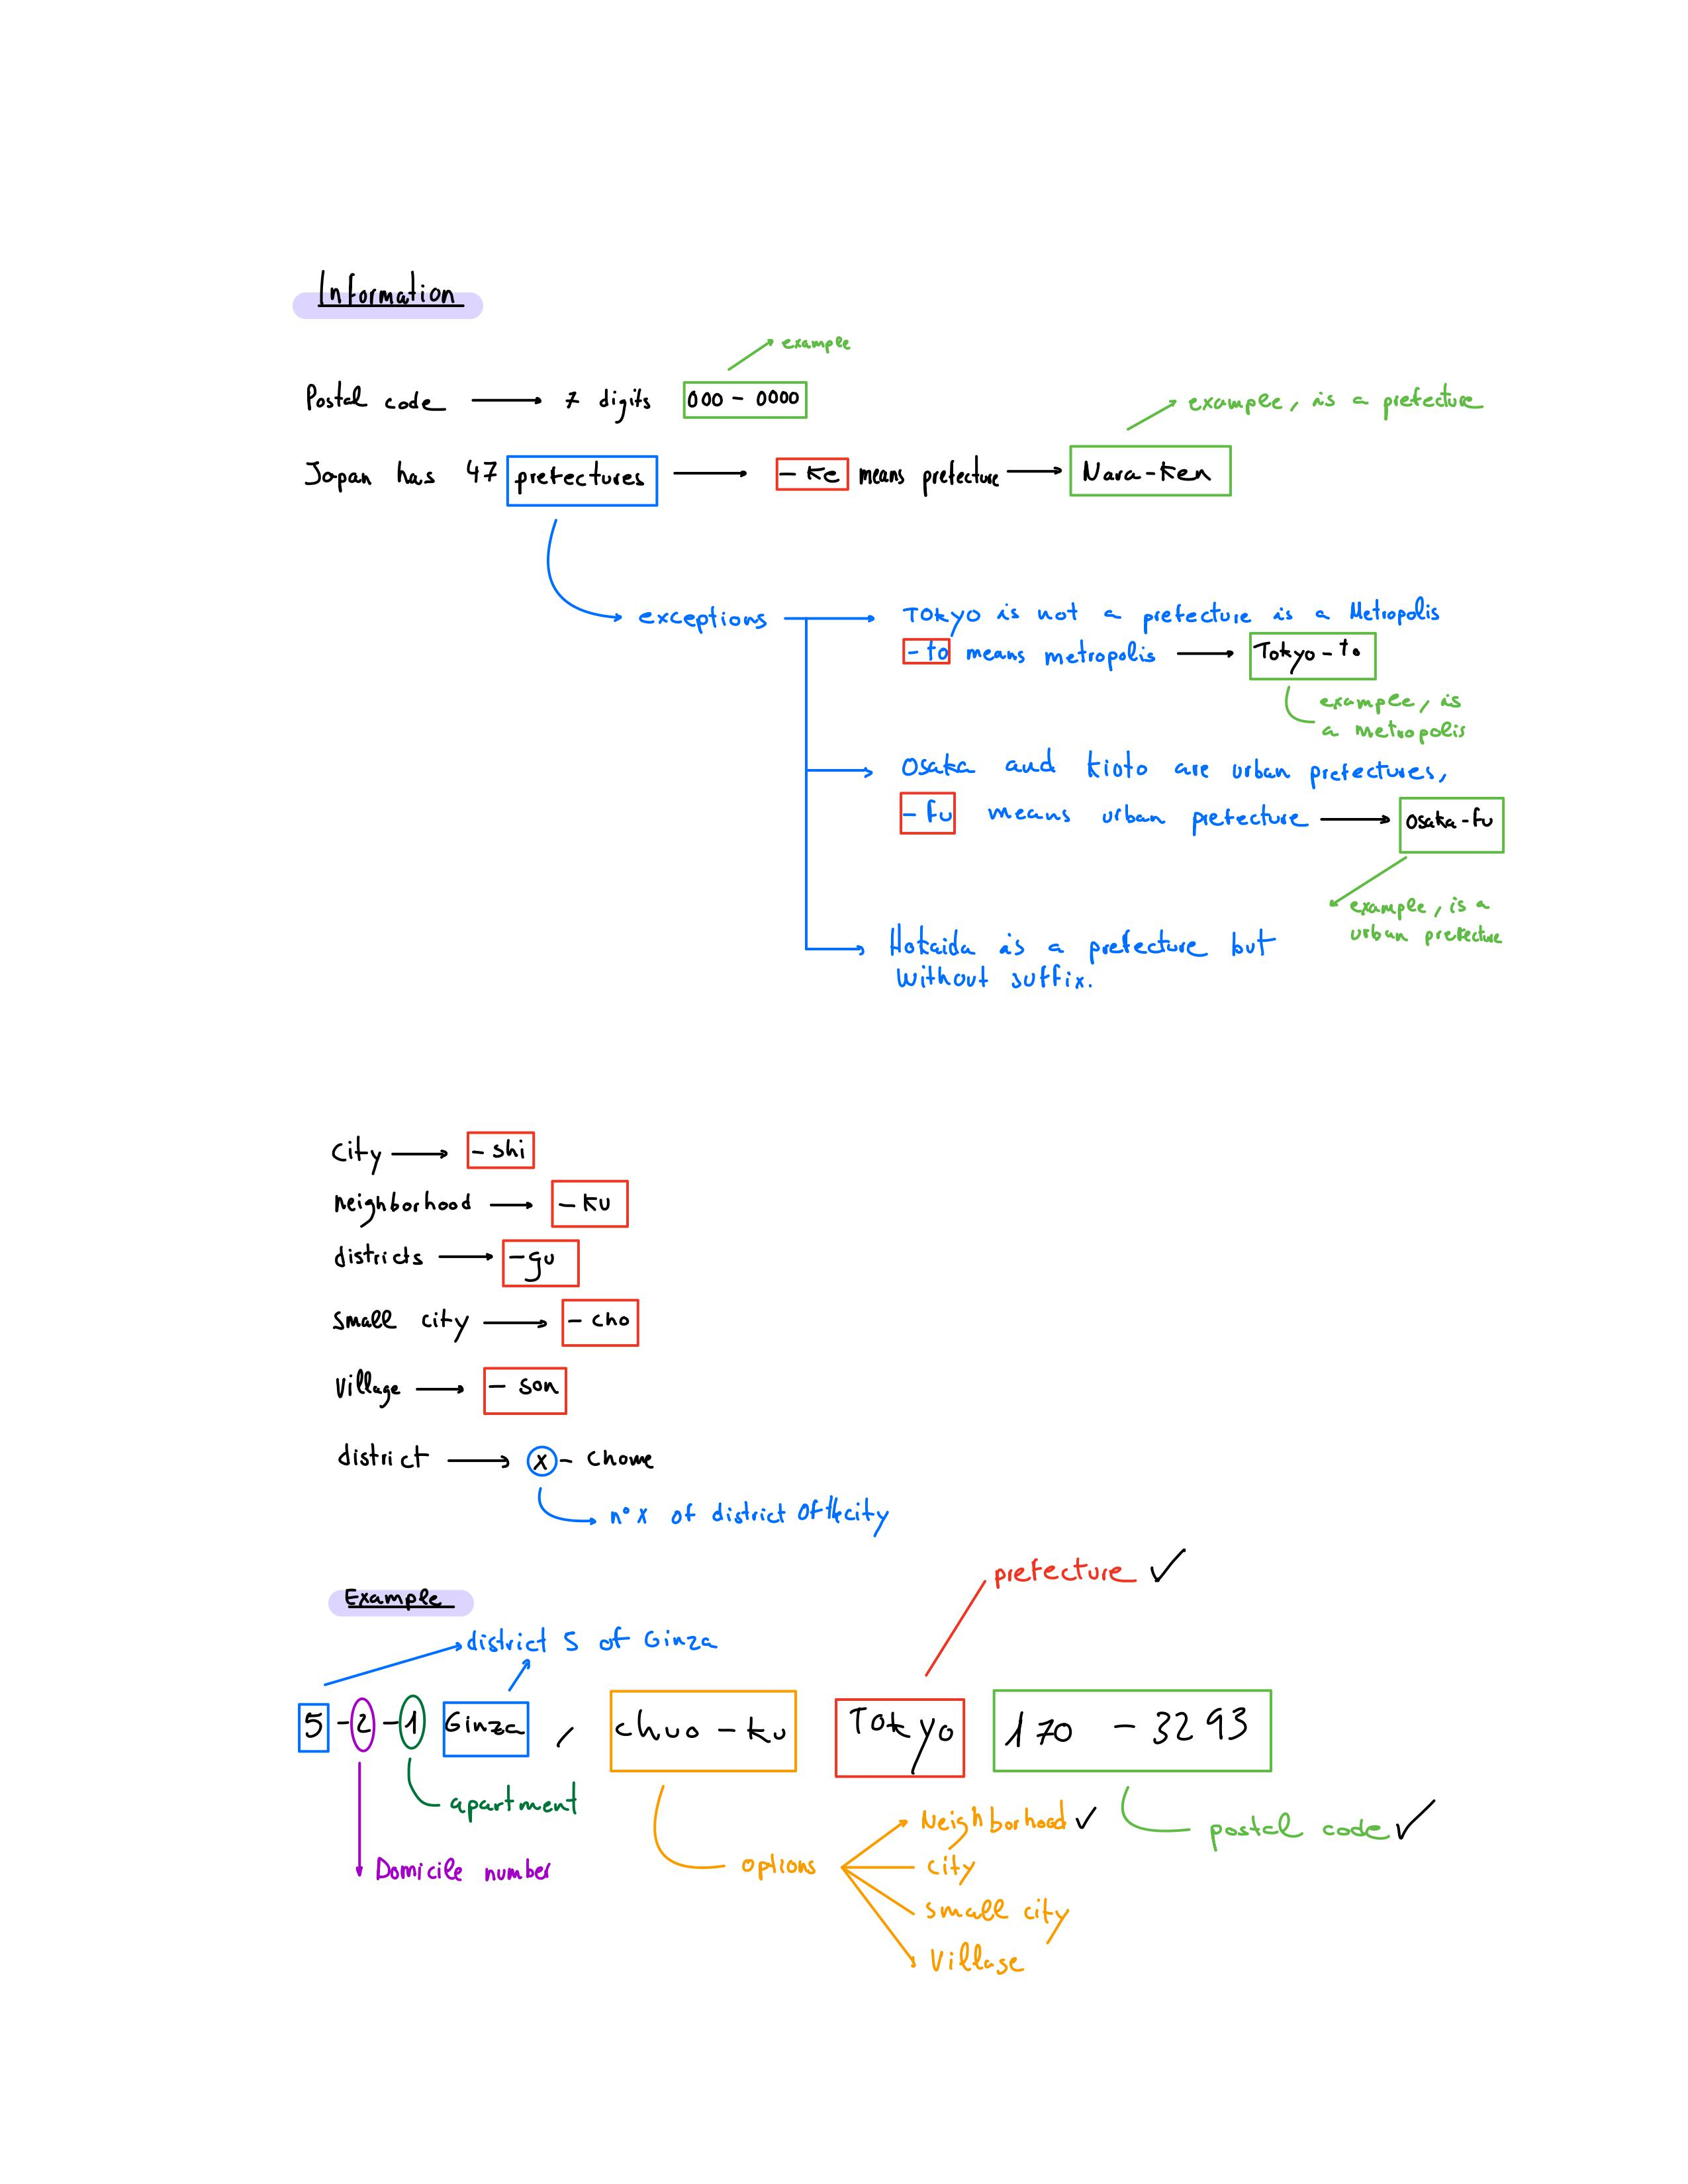

###  House Number and Street

As we can see, from what we consider to be complete in this assignmet, that while a European address it is usually constituted by the street, house number, city and postal code, in Japan is little diferent where there is no street in the address, instead all the information that represents the exact location of a house in a city, is in what we will consider the house number in our classifier script.
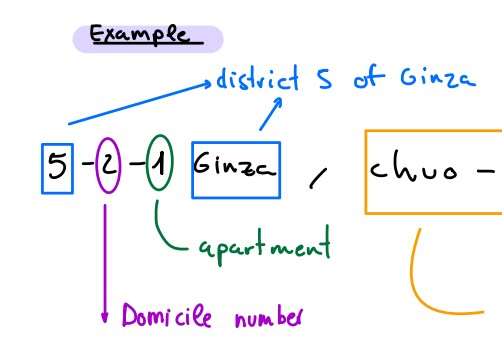
And as we can see in the example above, in the house number we have information about the district, the domicile number and the apartment, the street not being necessary. To do this for our assignment, to consider a Japanese address without a street as complete we simply removed the street validation when it is a Japanese address.

`complete = 1 if (street or country =='JP' or country == 'KR' or country == 'CN') and house_number and post_code and city else 0`

### Prefecture and Postal Code

A complete Japanese postal code has seven digits separated by a hyphen between the third and fourth digits, where the first 3 digits represent the prefecture, and for that reason we considered an address without prefecture as complete, because this information was already present in the postal code.
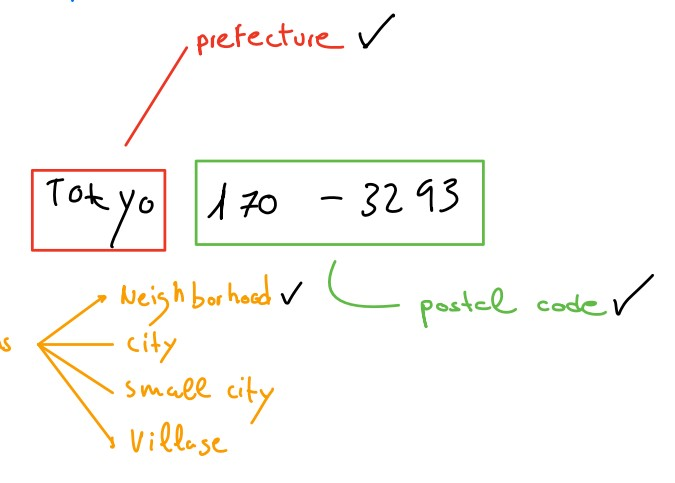

To conclude, to have a Japanese or other Asian address, as they are very similar, as complete, it was enough to present the house number, the city and the postal code, ignoring the street name, unlike in European countries.
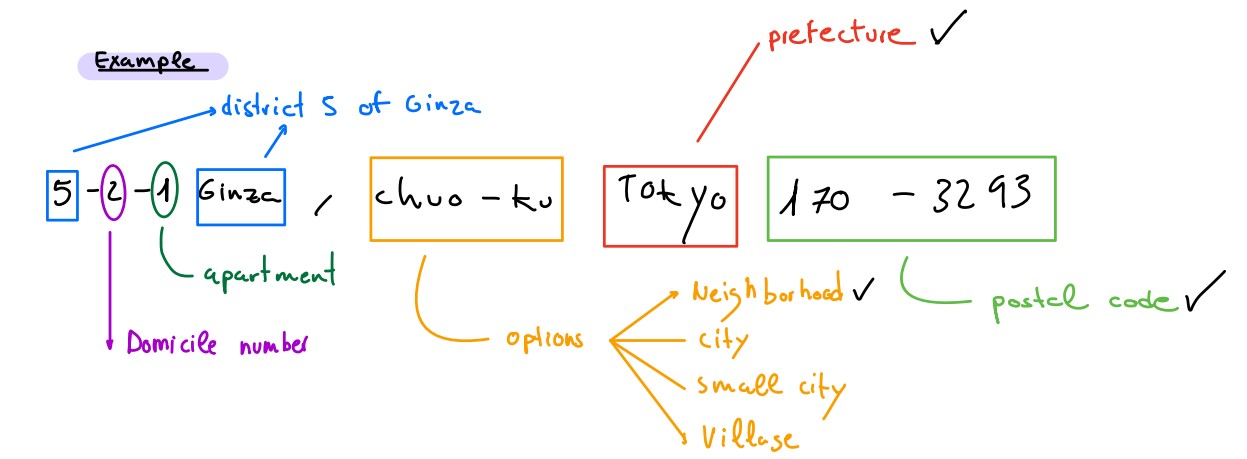

#### Asian Postal Code Fix

In Asian postal codes it was observed that many of the addresses came without a hyphen, which would cause various classifying errors when the address was parsed by the library. So, to correct this error, a small fix has been added to the code in which an address a 7-digit number will be searched, in the case of Japan and Korea, and add the hyphen between the third and fourth digits.

In [5]:
import re

def validate_asian_address_before_api(address, country):
    
    if country == 'JP': return validate_asian_postal_code_before_api(address, 7)
    elif country == 'CN' or country == 'KR': return validate_asian_postal_code_before_api(address, 6)


def validate_asian_postal_code_before_api(address, number):

    japanese_postal_code = re.findall(fr'\b\d{{{number}}}\b', address)
    
    if japanese_postal_code:
      
        old_postal_code = japanese_postal_code[0]
        new_postal_code = old_postal_code[:3] + "-" + old_postal_code[3:]
        return address.replace(old_postal_code, new_postal_code)


if __name__ == '__main__':

    address = 'c/o NITTO DENKO CORPORATION,  1-1-2,  Shimohozumi, Ibaraki-shi,  Osaka,  5678680'
    country = 'JP'
    print(f'Before: {address}')
    
    address = validate_asian_address_before_api(address, country)
    
    print(f'After: {address}')

Before: c/o NITTO DENKO CORPORATION,  1-1-2,  Shimohozumi, Ibaraki-shi,  Osaka,  5678680
After: c/o NITTO DENKO CORPORATION,  1-1-2,  Shimohozumi, Ibaraki-shi,  Osaka,  567-8680


## Classification of Australlian addresses
A lot of Australian addresses are also classified incorrectly, although they are, in fact, complete:
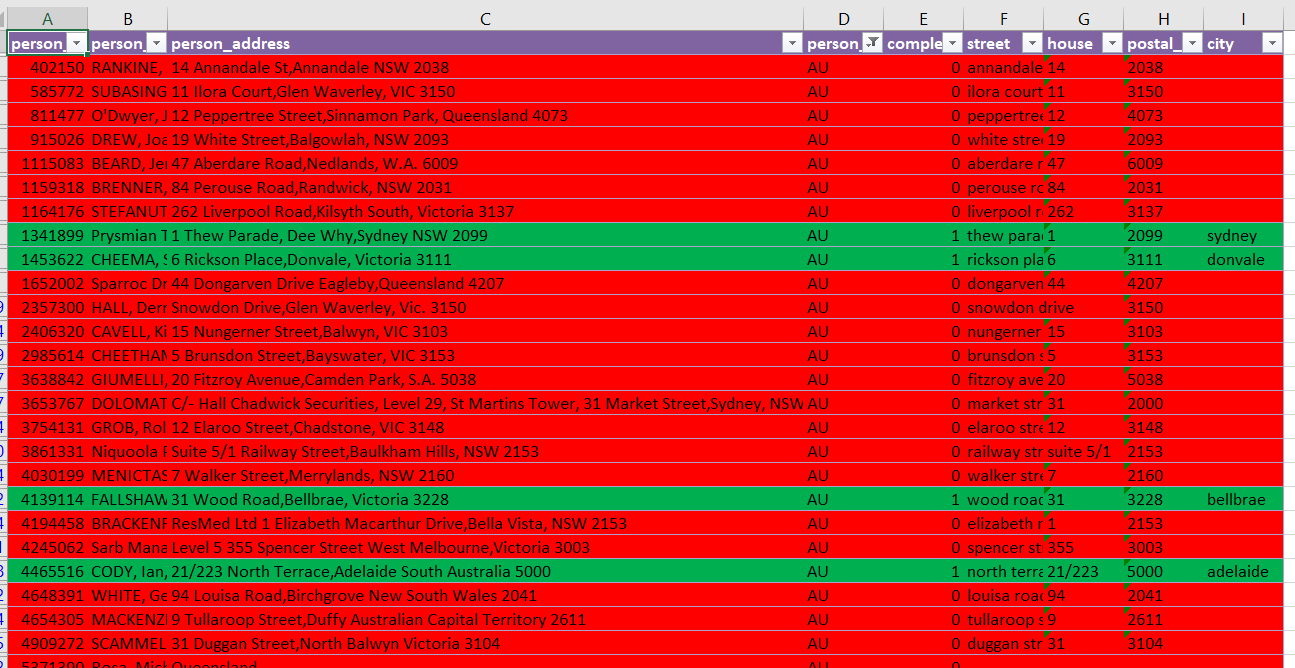
It is because for bigger cities (Melbourne, Sidney, etc.) instead of city a suburb is written to the address instead, and the `libpostal` tool is smart enough to tell the difference between a city and an Australian suburb:
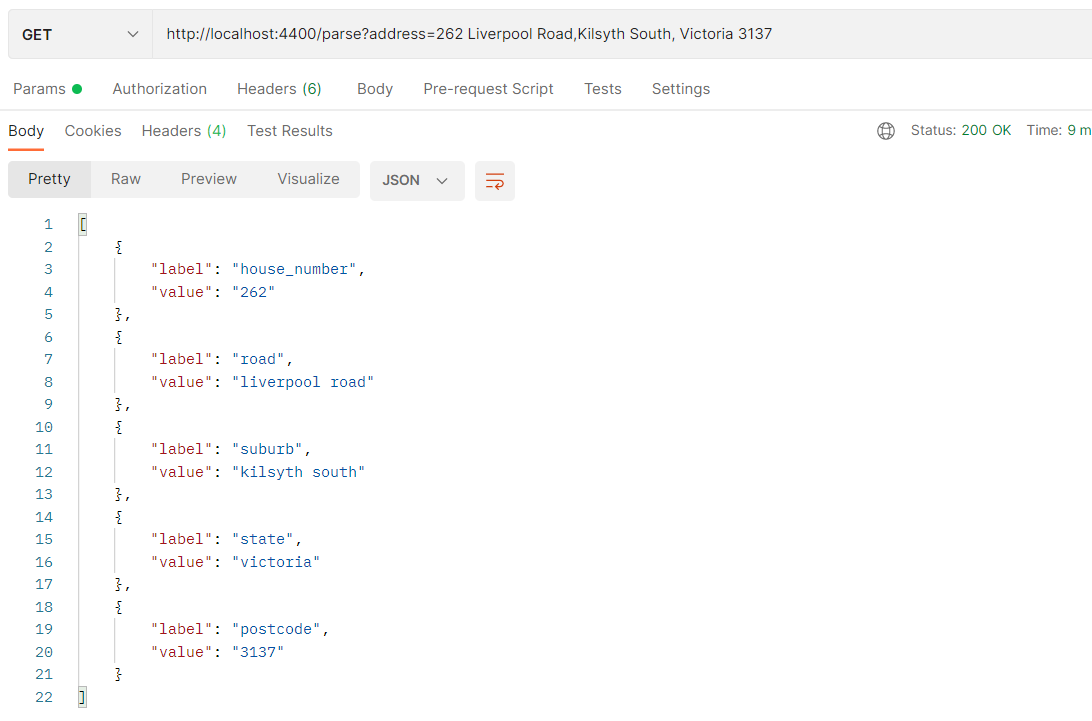

A simple fix for the problem is to treat a suburb as a city if the country is Australia:
```python
def enrich_row_with_address_details(row):
    ...

    # Try and resolve cities for specific countries
    if not city:
        # Australian addresses often have suburbs instead of cities in the addresses 
        if country == 'AU':
            suburbs = collect_property_list('suburb', unmapped_response)
            city = suburbs[0] if len(suburbs) > 0 else None     
    ...
    
    return complete, street, house_number, post_code, city
```

After the update Australian addresses are being qualified more correctly:
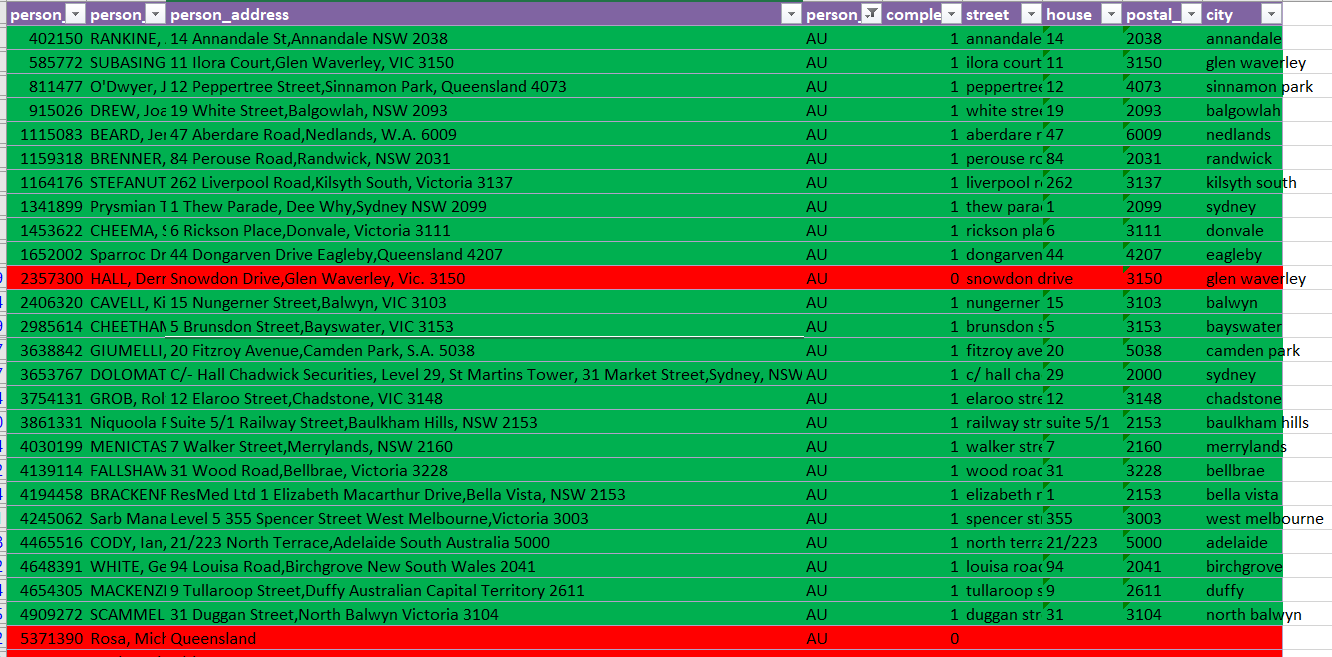

## Classification of Russian addresses
For many Russian house addresses the city's name is stated at the beggining of the address, often in such cases `libpostal` classifies the city as part of the street:

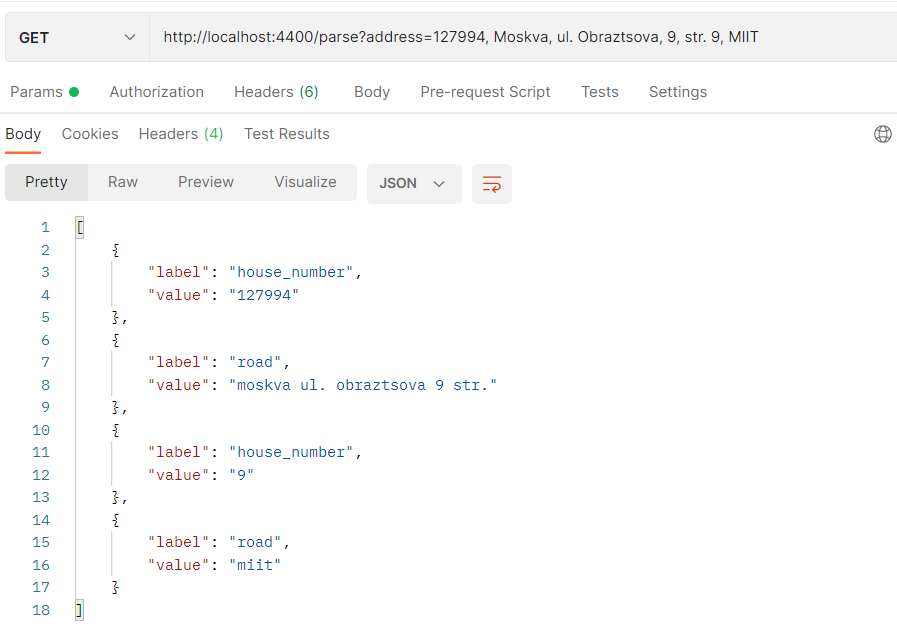

However, we can mitigate the issue by exploting a common pattern: in Russian addresses a common structure is that a city is followed by a street and in Russian street names usually begin with "ul." (shortened form of _ulica_, meaning street). Therefore, we can look for street names containing "ul." and parse the preceding token as a city name.
```python
def enrich_row_with_address_details(row):
    ...
    
    # Try and resolve cities for specific countries
    if not city:
        # Australian cities often have suburbs instead of cities in the addresses 
        if country == 'AU':
            suburbs = collect_property_list('suburb', unmapped_response)
            city = suburbs[0] if len(suburbs) > 0 else None
        # Cities of Russian addresses sometimes go before the street (moskva ul. b. spasskaja 25) and get classified as roads
        elif len(re.findall(r'ul\.', address)) > 0:
            for city_road in filter(lambda road: len(re.findall(r'ul\.', road)) > 0,  roads):
                match = re.search(r'(\w+)\s+ul\.', city_road)
                if match and match.group(1):
                    city = match.group(1)
                    print('RESOLVED CITY ', city, ' FROM address ', address)
                    break    
    ...
    
    return complete, street, house_number, post_code, city
```
By looking at the logging results we can see that the strategy works fine:
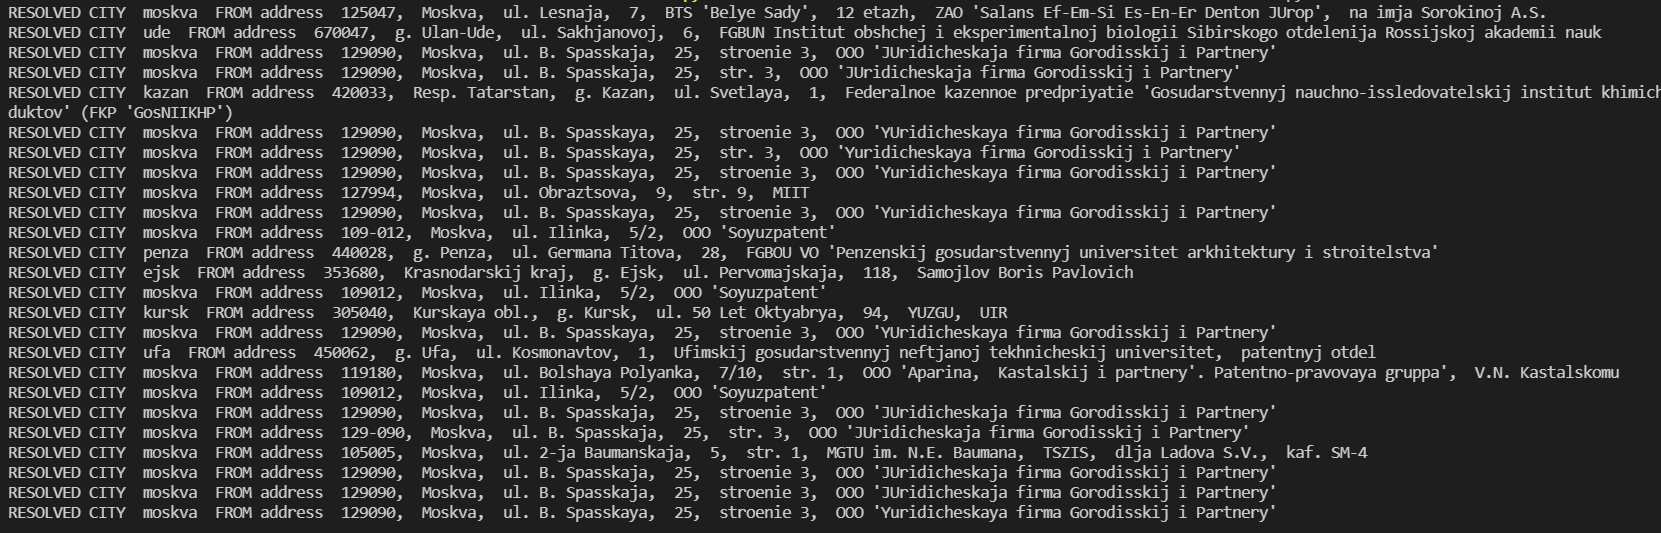

# Final code (logging commented out)

In [7]:
import pandas as pd
import re
import requests
import time

LIBPOSTAL_API_PARSE_PATH = 'http://localhost:4400/parse'

DATA_INPUT_FILENAME = 'input.txt'
DATA_OUTPUT_FILENAME = 'classified.xlsx'

POSTAL_CODE_REGEX = r'\b(?<!\-)((([a-zA-Z]{1,3}[-\s]?)?\d{4,8}([-]\d{3})?)|((?=\w*\d)[\w]{3,4}[-\s]?(?=\w*\d)[\w]{3})|(([a-zA-Z]{1,2}[-])?\d{2,3}[-\s]\d{2,3}))\b(?!-)'


def read_DataFrame_from_file():
    return pd.read_csv(DATA_INPUT_FILENAME, delimiter='\t', keep_default_na=False)


def write_DataFrame_to_excel(df: pd.DataFrame):
    sheet_name = 'Classified'

    with pd.ExcelWriter(DATA_OUTPUT_FILENAME, engine='xlsxwriter') as writer:
        df.to_excel(writer, sheet_name=sheet_name, index=False)

        worksheet = writer.sheets[sheet_name]
        # format all data as a table
        worksheet.add_table(0, 0, df.shape[0], df.shape[1]-1, {
            'columns': [{'header': col_name} for col_name in df.columns],
            'style': 'Table Style Medium 5'
        })
        # Widen the address column
        worksheet.set_column('C:C', 70)

        # Add formatting - red for negative, green - for positive qualification
        redFormat = writer.book.add_format(
            {'bg_color': '#FF0000', 'font_color': '#000000'})
        greenFormat = writer.book.add_format(
            {'bg_color': '#00B050', 'font_color': '#000000'})
        worksheet.conditional_format(0, 0, df.shape[0], df.shape[1]-1, {'type': 'formula',
                                          'criteria': '=$E1=0',
                                          'format': redFormat})
        worksheet.conditional_format(0, 0, df.shape[0], df.shape[1]-1, {'type': 'formula',
                                          'criteria': '=$E1=1',
                                          'format': greenFormat})


def extract_postal_code(input):
    match = re.search(POSTAL_CODE_REGEX, input)
    if (match is not None):
        return match.group(0)
    return None


def collect_property_list(property, array):
    return list(map(lambda row: row['value'] , filter(lambda row: row['label'] == property , array)))


def get_normalized_house_number_and_postal(house_numbers):
    house_num = None
    postal = None

    for number in house_numbers:
        if house_num and postal:
            break
        possible_postal = extract_postal_code(number)

        if not postal and possible_postal:
            postal = possible_postal
            number = number.replace(possible_postal, '').strip()

        if not house_num and number and len(re.findall(r'\d+', number)) > 0:
            house_num = number

    return house_num, postal


def enrich_row_with_address_details(row):
    error_response = [0, None, None, None, None]

    address = row['person_address']
    country = row['person_ctry_code']

    if not address:
        return error_response
    
    address = address.replace(',', ', ')
    address = address.replace(' - ', '-')

    if len(address.split()) < 3:
        return error_response

    address = validate_asian_address_before_api(address, country)

    try:
        unmapped_response = requests.get(LIBPOSTAL_API_PARSE_PATH, params={ 'address': address }).json()
    except Exception as e:
        print('Failed to parse address {} | error: {}'.format(address, e))
        return error_response

    roads = collect_property_list('road', unmapped_response)
    house_numbers = collect_property_list('house_number', unmapped_response)
    post_codes = collect_property_list('postcode', unmapped_response)
    cities = collect_property_list('city', unmapped_response)

    street = roads[0] if len(roads) > 0 else None
    house_number = house_numbers[0] if len(house_numbers) > 0 else None
    post_code = post_codes[0] if len(post_codes) > 0 else None
    city = cities[0] if len(cities) > 0 else None

    # Try and resolve cities for specific countries
    if not city:
        # Australian cities often have suburbs instead of cities in the addresses 
        if country == 'AU':
            suburbs = collect_property_list('suburb', unmapped_response)
            city = suburbs[0] if len(suburbs) > 0 else None
        # Cities of Russian addresses sometimes go before the street (moskva ul. b. spasskaja 25) and get classified as roads
        elif len(re.findall(r'ul\.', address)) > 0:
            for city_road in filter(lambda road: len(re.findall(r'ul\.', road)) > 0,  roads):
                match = re.search(r'(\w+)\s+ul\.', city_road)
                if match and match.group(1):
                    city = match.group(1)
#                     print('RESOLVED CITY ', city, ' FROM address ', address)
                    break    

    if house_number and not post_code:
        # Try and resolve a postal code possibly classified as a house number
        tmp_house_num, tmp_postal = get_normalized_house_number_and_postal(house_numbers)
        if tmp_house_num and tmp_postal:
            house_number = tmp_house_num
            post_code = tmp_postal
#             if street and house_number and post_code and city:
#                 print('NORMALIZED POSTAL CODE FROM HOUSE NUMBER FOR ', address)

    
    complete = 1 if (street or country =='JP' or country == 'KR' or country == 'CN') and house_number and post_code and city else 0

    return complete, street, house_number, post_code, city


def validate_asian_postal_code_before_api(address, number):

    japanese_postal_code = re.findall(fr'\b\d{{{number}}}\b', address)
    
    if japanese_postal_code:
      
        old_postal_code = japanese_postal_code[0]
        new_postal_code = old_postal_code[:3] + "-" + old_postal_code[3:]
        return address.replace(old_postal_code, new_postal_code)
                
    return address

def validate_asian_address_before_api(address, country):
    
    if country == 'JP': return validate_asian_postal_code_before_api(address, 7)
    elif country == 'CN' or country == 'KR': return validate_asian_postal_code_before_api(address, 6)
    else: return address


def classify_address(dataFrame: pd.DataFrame):
    dataFrame[['complete', 'street', 'house', 'postal_code', 'city']]=dataFrame.apply(
        enrich_row_with_address_details, axis=1, result_type='expand')
    return dataFrame


if __name__ == '__main__':

    start=time.time()

    classified=classify_address(read_DataFrame_from_file())
    write_DataFrame_to_excel(classified)

    end=time.time()

    print(f"\nExecution time in seconds: {end - start}")



Execution time in seconds: 35.471481800079346
